# TensorFlow Network finding

This notebook will work finding the best trade-off for TensorFlow neural network, using previous data transformation

**Main goals are**: 
- Use our understanding



In [2]:
IMAGE_SIZE = [163, 220]

In [3]:
from local_lib.dataset import retreiveDatasetFromCsv
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from local_lib.non_zero_transformer import NonZeroTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
import numpy as np
from sklearn.preprocessing import MinMaxScaler


dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

In [4]:
pipeline = Pipeline([
    ('non_zero_tr', NonZeroTransformer()),
    ('mask_tr', MaskSeuilTransformer(strategy="combined")),
    ('minmax', MinMaxScaler())
    ])

In [5]:
# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))


In [6]:
import copy

# Make a copy of the list
y_simpler = copy.deepcopy(y)
y_simpler[y_simpler == 2] = 1
np.unique(y_simpler)

y = y_simpler

In [92]:
print(X.shape)
print(y.shape)

(5856, 35860)
(5856,)


In [8]:
import keras

from tensorflow.keras.callbacks import Callback

class BatchLossLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

batch_loss_logger = BatchLossLogger()


In [9]:
initial_learning_rate = 0.015
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [10]:
METRICS = [
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        ]

In [11]:
#Reshape to 2D
X_reshaped = X.reshape((X.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

In [12]:
X_reshaped.shape

(5856, 163, 220, 1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


In [14]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.7),
    
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(1, activation="sigmoid")
])

In [15]:
model = Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.7),
    
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(1, activation="sigmoid")
])

In [16]:
import tensorflow as tf

# Compile the model with the learning rate schedule
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='binary_crossentropy', metrics=METRICS)

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def fitModelAndPlot(model,X_train,y_train, X_test, y_test, nb_epochs = 10, batch_size = 32, validation_split_percentage = 0.2):
    history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=validation_split_percentage, callbacks=[checkpoint_cb, early_stopping_cb, batch_loss_logger])
    
    test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc}, Test Loss: {test_loss}, Test Recall: {test_recall}, Test Precision: {test_precision}")

    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 14))

    plt.subplot(3, 2, 1)
    plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(3, 2, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(3, 2, 4)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(loc='best')

    plt.subplot(3, 2, 5)
    plt.plot(batch_loss_logger.batch_losses, label='Batch Loss')
    plt.title('Batch Loss During Training')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    # plt.subplot(3, 2, 6)
    # plt.plot(batch_loss_logger.batch_accuracy, label='Batch Accuracy')
    # plt.plot(batch_loss_logger.batch_val_accuracy, label='Batch Validation Accuracy')
    # plt.title('Batch Accuracy and Validation Accuracy During Training')
    # plt.xlabel('Batch')
    # plt.ylabel('Accuracy and Validation Accuracy')
    # plt.legend(loc='best')

    # print(batch_loss_logger.batch_logs)


    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')


    plt.tight_layout()
    plt.show()


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 56s 404ms/step - binary_accuracy: 0.7708 - loss: 0.5401 - precision: 0.8453 - recall: 0.8395 - val_binary_accuracy: 0.7076 - val_loss: 4.9735 - val_precision: 0.7179 - val_recall: 0.9572
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 45s 384ms/step - binary_accuracy: 0.8785 - loss: 0.3015 - precision: 0.9035 - recall: 0.9345 - val_binary_accuracy: 0.7022 - val_loss: 2.3812 - val_precision: 0.7067 - val_recall: 0.9801
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 45s 378ms/step - binary_accuracy: 0.8996 - loss: 0.2487 - precision: 0.9246 - recall: 0.9378 - val_binary_accuracy: 0.8965 - val_loss: 0.2929 - val_precision: 0.9619 - val_recall: 0.8869
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 46s 390ms/step - binary_accuracy: 0.9150 - loss: 0.2161 - precision: 0.9346 - recall: 0.9501 - val_binary_accuracy: 0.7524 - val_loss: 0.8193 - val_precision: 0.7448 - val_recall: 0.9817
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 45s 384ms/step - binary_accuracy: 0.9331 - loss: 0.1

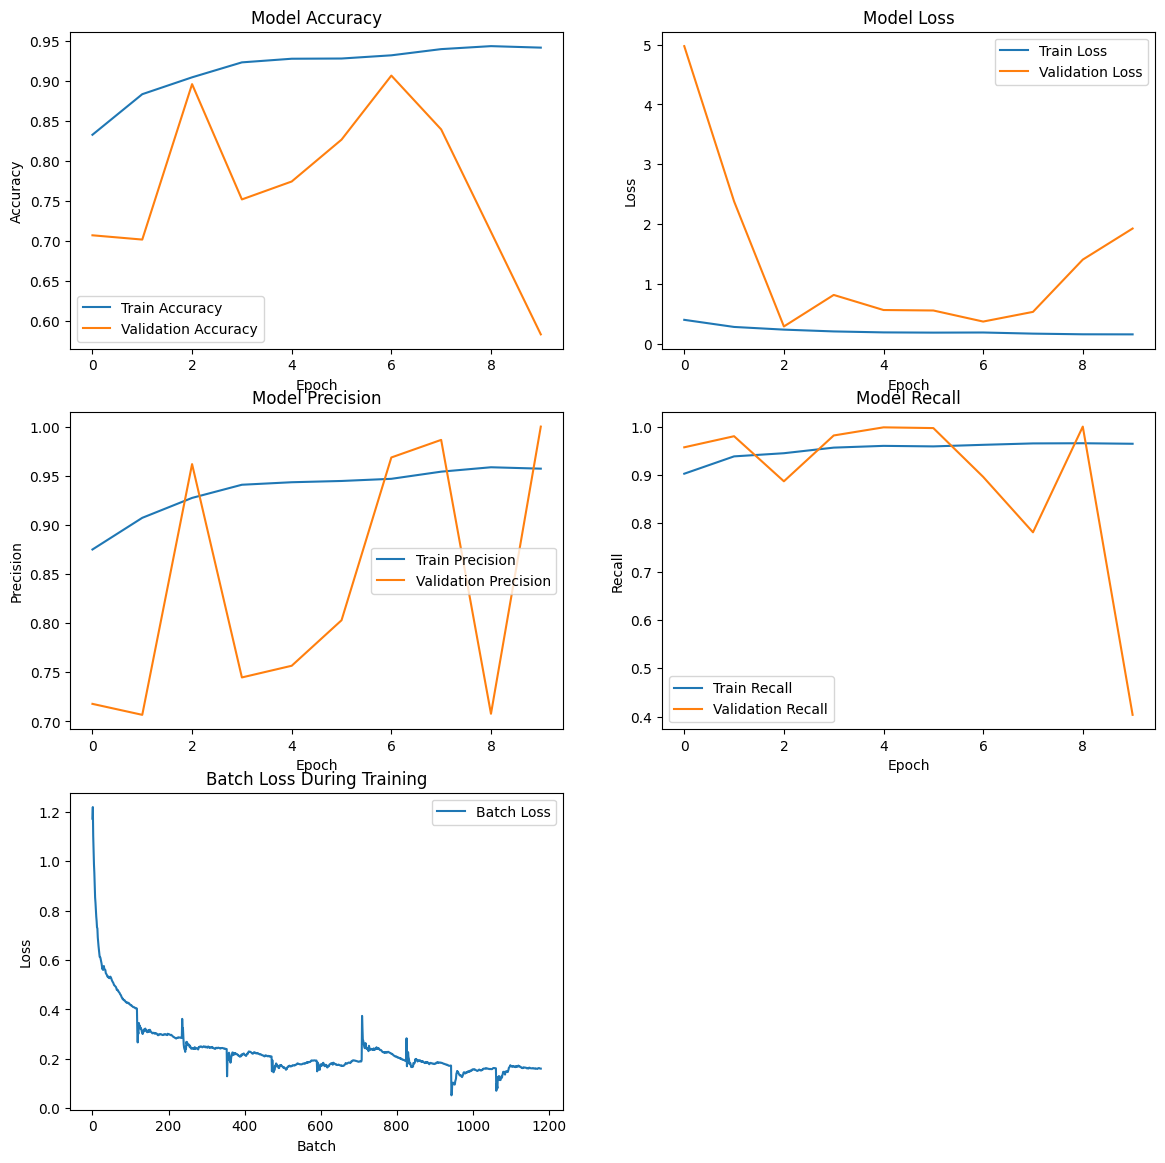

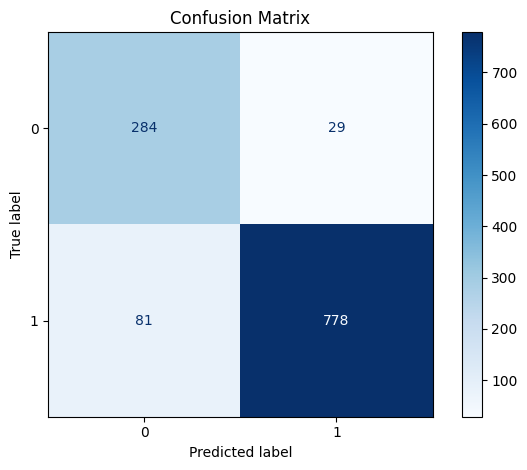

In [102]:
fitModelAndPlot(model,X_train,y_train,X_test,y_test)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - binary_accuracy: 0.9251 - loss: 0.1944 - precision: 0.9388 - recall: 0.9607 - val_binary_accuracy: 0.6980 - val_loss: 2.0043 - val_precision: 0.6980 - val_recall: 1.0000
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - binary_accuracy: 0.9415 - loss: 0.1658 - precision: 0.9584 - recall: 0.9630 - val_binary_accuracy: 0.7172 - val_loss: 1.3467 - val_precision: 0.7154 - val_recall: 0.9878
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - binary_accuracy: 0.9362 - loss: 0.1571 - precision: 0.9534 - recall: 0.9585 - val_binary_accuracy: 0.8655 - val_loss: 0.4264 - val_precision: 0.9125 - val_recall: 0.8930
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - binary_accuracy: 0.9473 - loss: 0.1490 - precision: 0.9581 - recall: 0.9706 - val_binary_accuracy: 0.8751 - val_loss: 0.3822 - val_precision: 0.9296 - val_recall: 0.8884
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - binary_accuracy: 0.9521 - loss: 0.1312 - precision: 0.9643 -

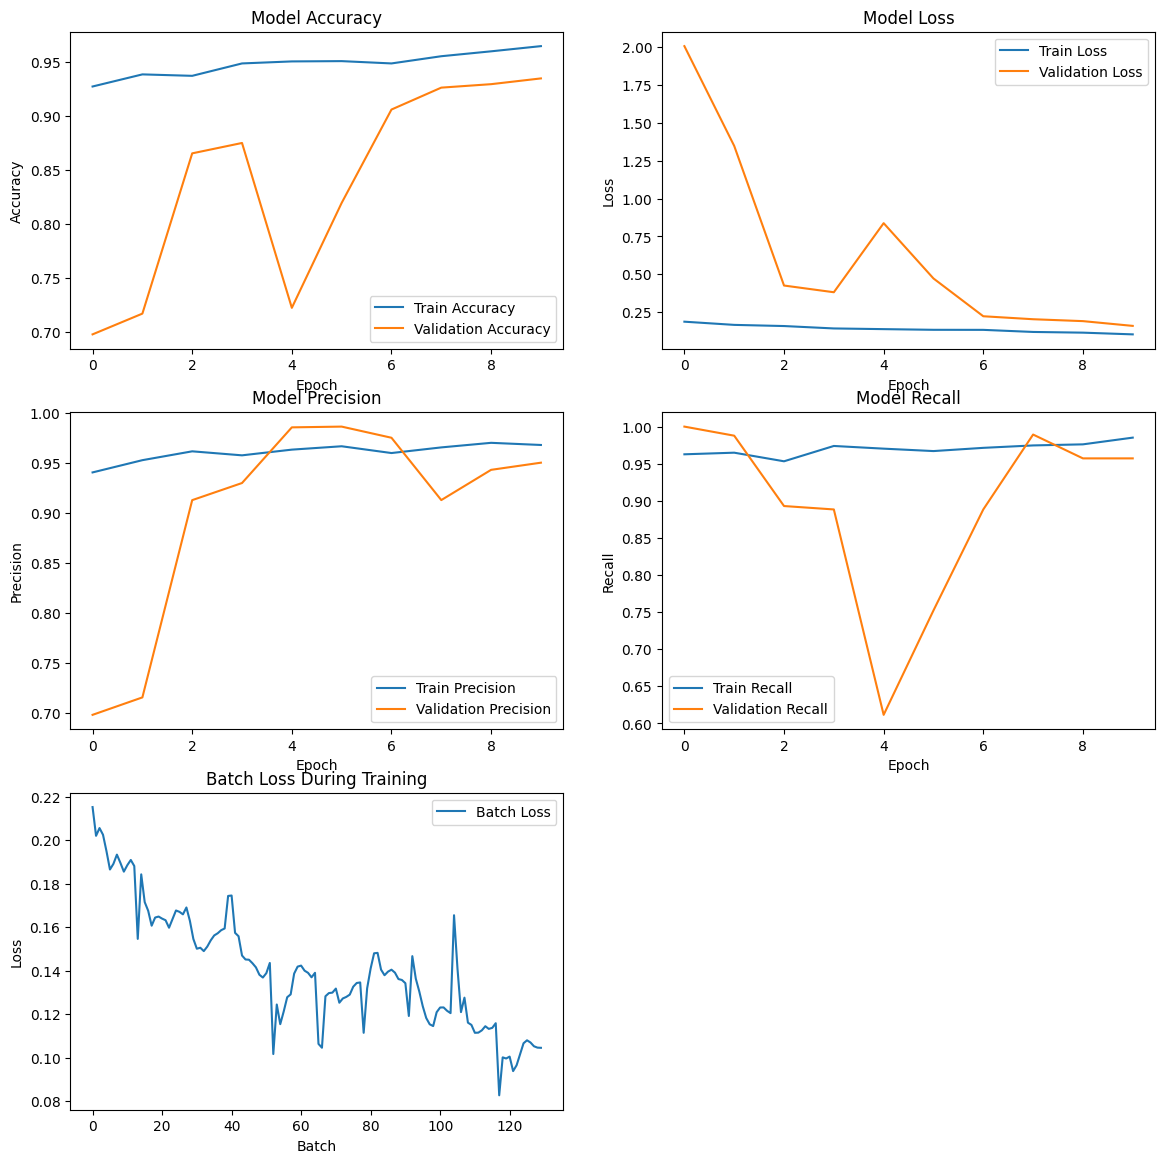

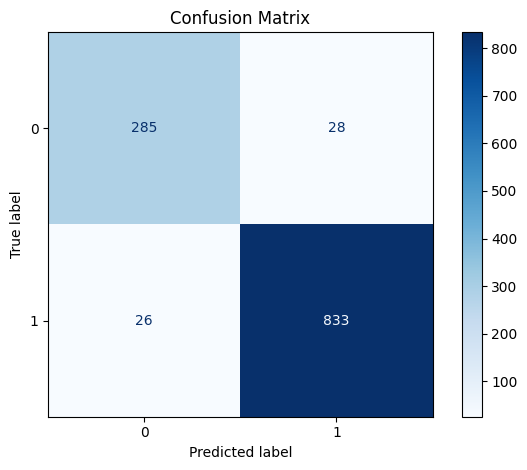

In [103]:
fitModelAndPlot(model,X_train,y_train,X_test,y_test,batch_size=300)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - binary_accuracy: 0.9302 - loss: 0.1824 - precision: 0.9370 - recall: 0.9691 - val_binary_accuracy: 0.9360 - val_loss: 0.2401 - val_precision: 0.9641 - val_recall: 0.9434
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - binary_accuracy: 0.9497 - loss: 0.1387 - precision: 0.9577 - recall: 0.9748 - val_binary_accuracy: 0.9242 - val_loss: 0.2825 - val_precision: 0.9771 - val_recall: 0.9128
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - binary_accuracy: 0.9668 - loss: 0.0991 - precision: 0.9739 - recall: 0.9814 - val_binary_accuracy: 0.9349 - val_loss: 0.2057 - val_precision: 0.9655 - val_recall: 0.9404
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - binary_accuracy: 0.9579 - loss: 0.1119 - precision: 0.9644 - recall: 0.9790 - val_binary_accuracy: 0.9509 - val_loss: 0.1622 - val_precision: 0.9620 - val_recall: 0.9679
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - binary_accuracy: 0.9648 - loss: 0.1018 - precision: 0.9699 -

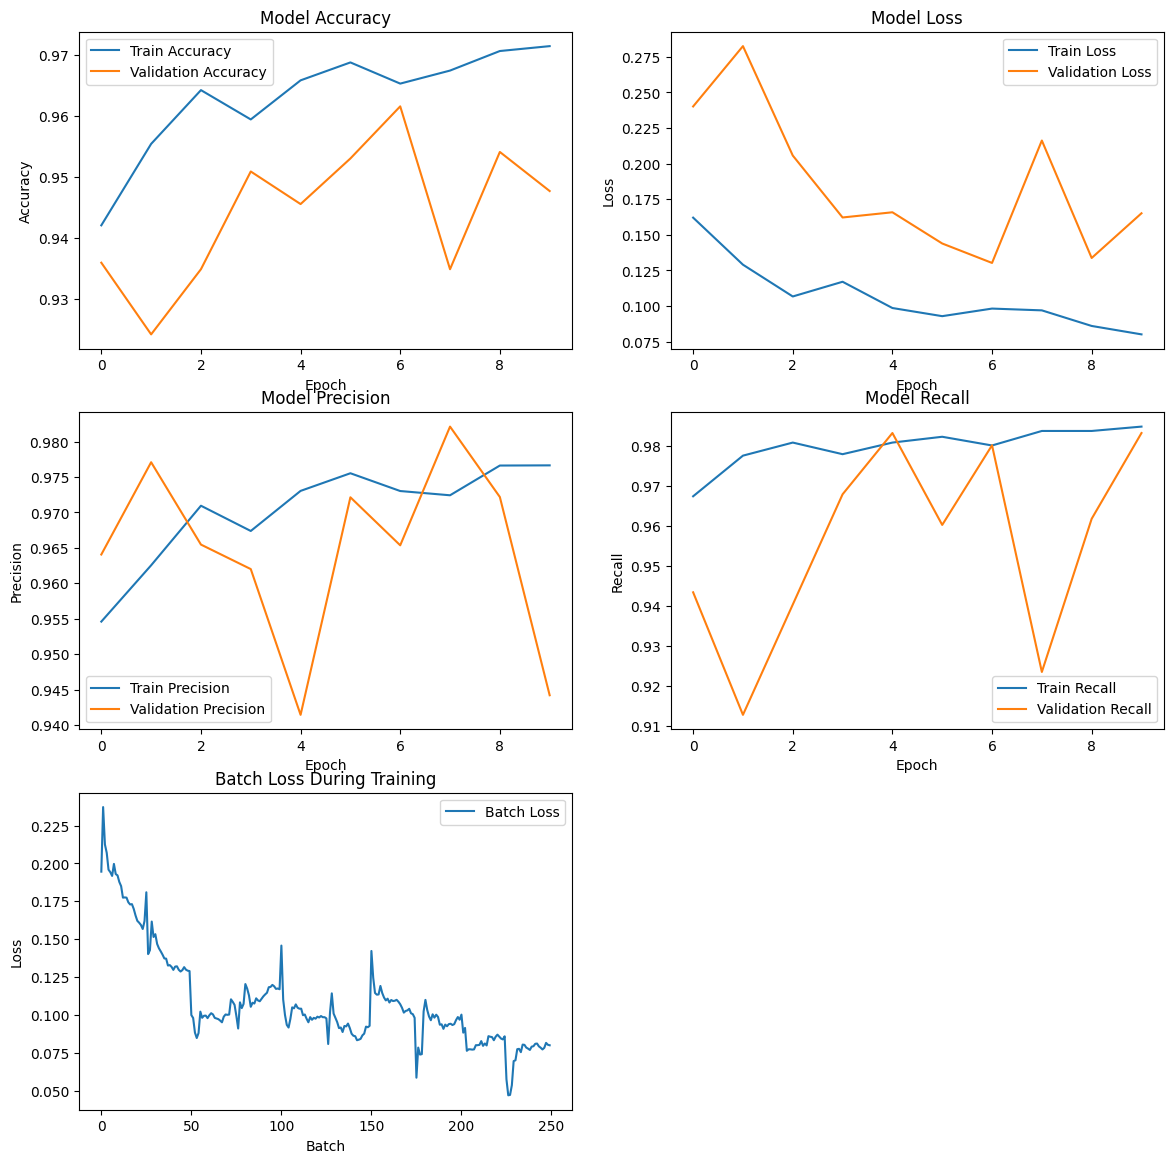

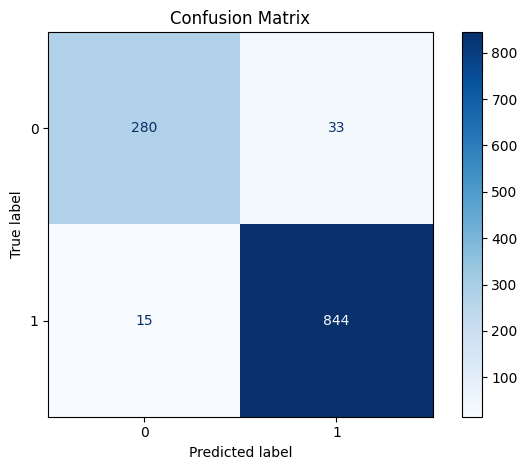

In [86]:
fitModelAndPlot(model,X_train,y_train,X_test,y_test, batch_size=150)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 151s 18s/step - binary_accuracy: 0.9691 - loss: 0.0889 - precision: 0.9774 - recall: 0.9808 - val_binary_accuracy: 0.9061 - val_loss: 0.2481 - val_precision: 0.8909 - val_recall: 0.9862
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 13s/step - binary_accuracy: 0.9731 - loss: 0.0810 - precision: 0.9785 - recall: 0.9852 - val_binary_accuracy: 0.9050 - val_loss: 0.2472 - val_precision: 0.8865 - val_recall: 0.9908
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - binary_accuracy: 0.9689 - loss: 0.0869 - precision: 0.9801 - recall: 0.9779 - val_binary_accuracy: 0.9136 - val_loss: 0.2462 - val_precision: 0.8952 - val_recall: 0.9924
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 36s 11s/step - binary_accuracy: 0.9737 - loss: 0.0810 - precision: 0.9774 - recall: 0.9872 - val_binary_accuracy: 0.9178 - val_loss: 0.2282 - val_precision: 0.9013 - val_recall: 0.9908
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - binary_accuracy: 0.9756 - loss: 0.0770 - precision: 0.9794 

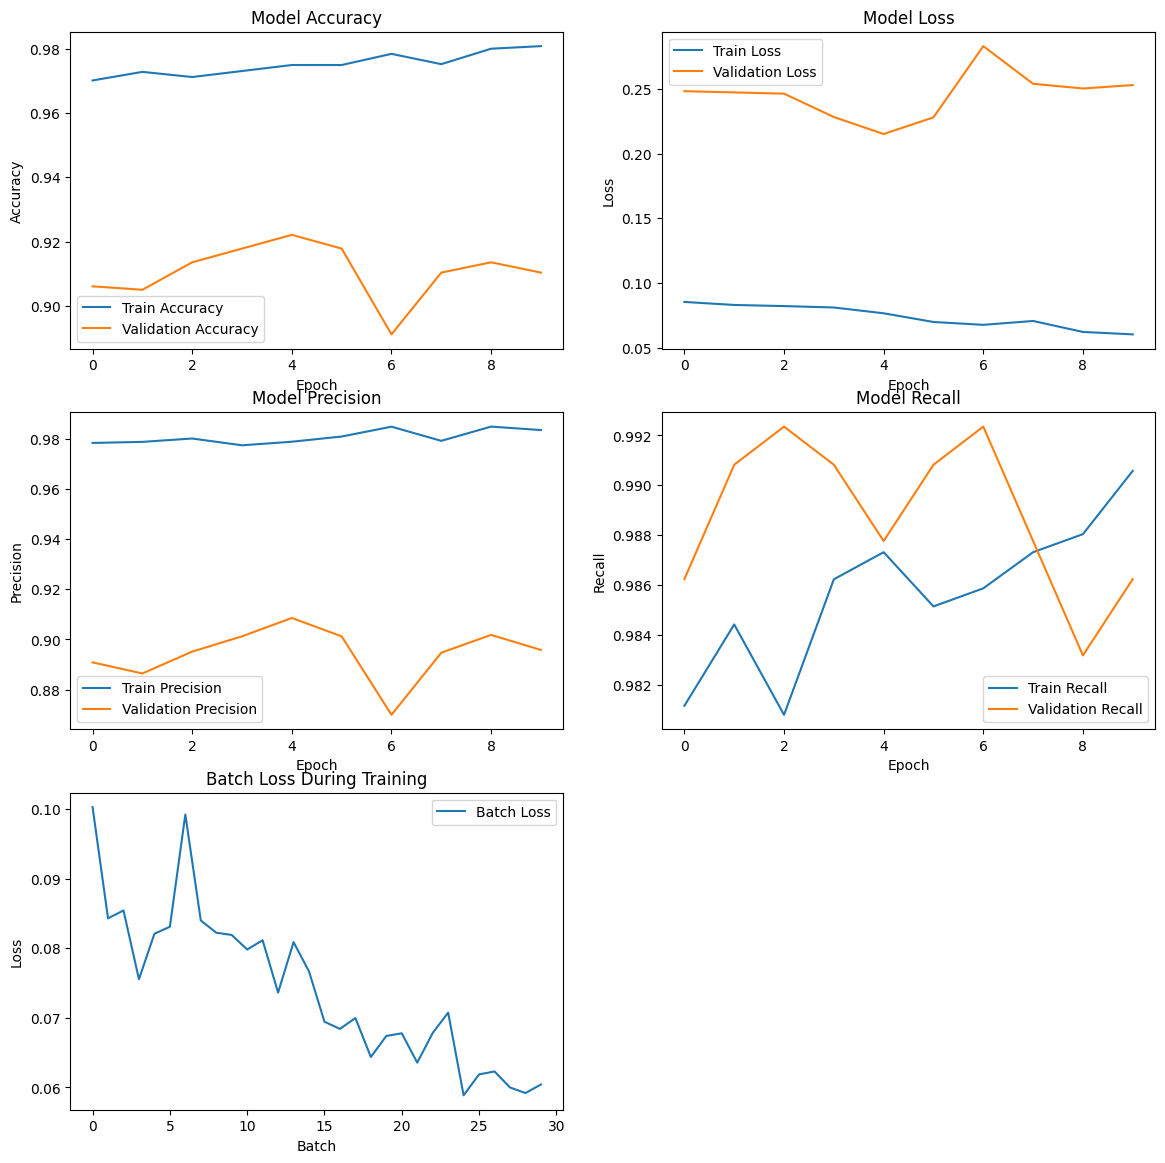

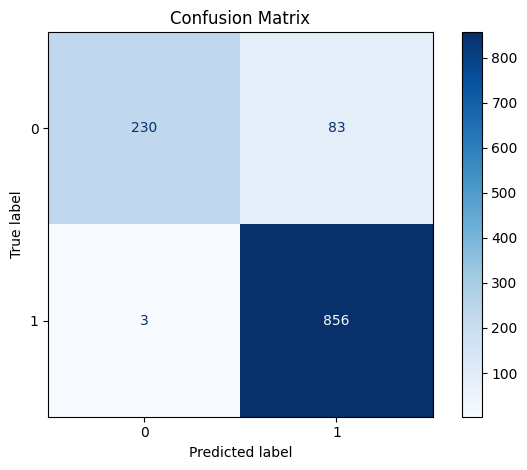

In [105]:
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,1464)